In [1]:
import pandas as pd
from docx import Document
import re
import pandas as pd
import torch
from transformers import BigBirdTokenizer,BigBirdModel,BigBirdForSequenceClassification
from torch import Tensor
import numpy as np
from collections import Counter
# from typing import list

In [2]:
# Data_csv = pd.read_csv("/home/ubuntu/working_directory/Bert_experimentation/new_dataframe_50000_100000.csv")
Data_csv = pd.read_csv("/home/ubuntu/cat_poc/llms/final_data.csv")
# Data_csv.drop('Unnamed: 0', axis=1, inplace=True)
Data_csv

,filename,text,level
0,15031-4983-FullBook.docx,"Learner Choice, Learning Voice\n\n\nLearner Vo...",Level 1
1,15031-4984-FullBook.docx,\n\nExistentialism: A Philosophical Inquiry\n\...,Level 1
2,15031-4985-FullBook.docx,"""The editors of this volume are the top practi...",Level 1
3,15031-4986-FullBook.docx,Black Power Music!\n\nBlack Power Music!: Prot...,Level 1
4,15031-4989-FullBook.docx,Home\n\n\nHome articulates a ‘critical geograp...,Level 1
...,...,...,...
1231,15032-5774-FullBook.docx,The Japanese LGBTQ+ Community in the World\n\n...,Level 3
1232,15032-5789-FullBook.docx,The Acquisition of English Grammar and Phonolo...,Level 3
1233,15032-5829-FullBook.docx,"\n‘New concepts, new words for them, new actio...",Level 3
1234,15032-5843-FullBook.docx,Translating Rumi into the West\n\n\nFocusing o...,Level 3


In [7]:
level_counts = Data_csv['level'].value_counts()
print(level_counts)

level
Level 1    980
Level 2    191
Level 3     65
Name: count, dtype: int64


In [8]:
sample_df = Data_csv.groupby("level").apply(lambda x: x.sample(60))

In [3]:
tokenizer = BigBirdTokenizer.from_pretrained('google/bigbird-roberta-base')
model = BigBirdForSequenceClassification.from_pretrained('google/bigbird-roberta-base', 
                                                         num_labels=3)

Some weights of the model checkpoint at google/bigbird-roberta-base were not used when initializing BigBirdForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BigBirdForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BigBirdForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BigBirdForSequenceClassifica

In [10]:
def split_tokens_into_smaller_chunks(input_id: Tensor,att_mask: Tensor, chunk_size: int, stride: int, minimal_chunk_length: int):
    input_id_chunks = [input_id[i : i + chunk_size] for i in range(0, len(input_id), stride)]
    mask_chunks = [att_mask[i : i + chunk_size] for i in range(0, len(att_mask), stride)]
    if len(input_id_chunks) > 1:
        # ignore chunks with less than minimal_length number of tokens
        input_id_chunks = [x for x in input_id_chunks if len(x) >= minimal_chunk_length]
        mask_chunks = [x for x in mask_chunks if len(x) >= minimal_chunk_length]
    return input_id_chunks, mask_chunks

# from typing import List

# def split_tokens_into_smaller_chunks(input_ids: List[int], attention_mask: List[int], chunk_size: int, stride: int, minimal_chunk_length: int):
#     input_id_chunks = [input_ids[i : i + chunk_size] for i in range(0, len(input_ids), stride)]
#     mask_chunks = [attention_mask[i : i + chunk_size] for i in range(0, len(attention_mask), stride)]
#     if len(input_id_chunks) > 1:
#         # ignore chunks with less than minimal_length number of tokens
#         input_id_chunks = [x for x in input_id_chunks if len(x) >= minimal_chunk_length]
#         mask_chunks = [x for x in mask_chunks if len(x) >= minimal_chunk_length]
#     return input_id_chunks, mask_chunks

def add_special_tokens_at_beginning_and_end(input_id_chunks, mask_chunks) -> None:
    """
    Adds special CLS token (token id = 101) at the beginning.
    Adds SEP token (token id = 102) at the end of each chunk.
    Adds corresponding attention masks equal to 1 (attention mask is boolean).
    """
    for i in range(len(input_id_chunks)):
        # adding CLS (token id 101) and SEP (token id 102) tokens
        input_id_chunks[i] = torch.cat([Tensor([101]), input_id_chunks[i], Tensor([102])])
        # adding attention masks  corresponding to special tokens
        mask_chunks[i] = torch.cat([Tensor([1]), mask_chunks[i], Tensor([1])])

def add_padding_tokens(input_id_chunks, mask_chunks) -> None:
    """Adds padding tokens (token id = 0) at the end to make sure that all chunks have exactly 512 tokens."""
    for i in range(len(input_id_chunks)):
        # get required padding length
        pad_len = 512 - input_id_chunks[i].shape[0]
        # check if tensor length satisfies required chunk size
        if pad_len > 0:
            # if padding length is more than 0, we must add padding
            input_id_chunks[i] = torch.cat([input_id_chunks[i], Tensor([0] * pad_len)])
            mask_chunks[i] = torch.cat([mask_chunks[i], Tensor([0] * pad_len)])

# def add_padding_tokens(input_id_chunks, mask_chunks) -> None:
#     """Adds padding tokens (token id = 0) at the end to make sure that all chunks have exactly 512 tokens."""
#     for i in range(len(input_id_chunks)):
#         # get required padding length
#         pad_len = 512 - len(input_id_chunks[i])
#         # check if list length satisfies required chunk size
#         if pad_len > 0:
#             # if padding length is more than 0, we must add padding
#             input_id_chunks[i] += [0] * pad_len
#             mask_chunks[i] += [0] * pad_len

def stack_tokens_from_all_chunks(input_id_chunks, mask_chunks):
    input_ids = torch.stack(input_id_chunks)
    attention_mask = torch.stack(mask_chunks)
    return input_ids.long(), attention_mask.int()

In [11]:
from sklearn.preprocessing import OneHotEncoder
import torch
import torch.nn.functional as F
from langchain.text_splitter import TokenTextSplitter
text_splitter_1 = TokenTextSplitter(chunk_size=300, chunk_overlap=128)
text_splitter_2 = TokenTextSplitter(chunk_size=150, chunk_overlap=64)
new_chunk_df = pd.DataFrame()
total_chunks = []  
total_att_mask = [] 
total_fnames = []
total_labels = []
total_chunk_counts = []
label2id = {"Level 1": 0, "Level 2": 1, "Level 3": 2}
chunks_count = 1
chunk_length = 2000
stride = 500
min_chunk_length = 256
length_total_labels = 0
chunk_len_list = []
token_len_list = []
for idx in range(sample_df.shape[0]):
# for idx in range(2):
    x = sample_df["text"].iloc[idx]
    # sentences = re.split(r'(?<=[.!?])\s+', x)
    # long_string = ' '.join(sentences)
    label = label2id[sample_df.iloc[idx]["level"]]
    # chunks = split_text_into_chunks(x, stride, chunk_length, min_chunk_length)
    chunks = text_splitter_1.split_text(x)
    # length_total_labels += len(chunks)
    tokenized_chunks = []
    for chunk in chunks:
        # print("chunk_length",len(chunk.split()))
        chunk_len_list.append(len(chunk.split()))
        tokens = tokenizer(chunk, truncation=True, padding=True, return_tensors="pt")
        if len(tokens['input_ids'][0]) > 512:
            sub_chunks = text_splitter_2.split_text(chunk)
            print(len(sub_chunks))
            for i in sub_chunks:
                tokens = tokenizer(chunk, truncation=True, padding=True, return_tensors="pt")
                tokenized_chunks.append(tokens)
            # print(len(tokens['input_ids'][0]))
        else:
            token_len_list.append(len(tokens['input_ids'][0]))
            tokenized_chunks.append(tokens)
    input_id_chunks = []
    mask_chunks = []
    for chunk in tokenized_chunks:
        input_id_chunks.extend(chunk["input_ids"])
        mask_chunks.extend(chunk["attention_mask"])
    add_padding_tokens(input_id_chunks, mask_chunks)
    label_vec = [label] * len(input_id_chunks)
    total_chunks.extend((input_id_chunks))
    total_att_mask.extend((mask_chunks))
    total_labels.extend((label_vec))


In [12]:
for i in total_chunks:
    if len(i) > 512:
        print(len(i))

In [13]:
len(total_labels)

174056

In [14]:
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, input_ids, attention_mask, labels_vec):
        self.input_ids = [chunk.long() for chunk in input_ids]
        # print("length in put ids:", len(self.input_ids))
        self.attention_mask = attention_mask
        self.labels_vec = labels_vec

    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, index):
        # print(self.labels_vec[index])
        return {
            'input_ids': self.input_ids[index].squeeze(),
            'attention_mask': self.attention_mask[index].squeeze(),
            'label': self.labels_vec[index]
        }

In [15]:
print(len(total_chunks))

174056


In [16]:
dataset =  CustomDataset(total_chunks,total_att_mask,total_labels)

In [17]:
len(dataset[0])

3

In [18]:
# len(dataset[0]['input_ids'])
for i in dataset:
    if len(i['input_ids']) != 512: 
        print(len(i['input_ids']))

In [19]:
len(total_labels)

174056

In [20]:
print(total_labels.count(0))
print(total_labels.count(1))
print(total_labels.count(2))


53043
55825
65188


In [21]:
from torch.utils.data import random_split
train_ratio = 0.8  # 80% for training
test_ratio = 0.2  # 20% for testing

num_samples = len(dataset)
train_size = int(train_ratio * num_samples)
test_size = num_samples - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


In [22]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=5,
                                           pin_memory=True,
                                           shuffle=True, 
                                           )
test_loader = torch.utils.data.DataLoader(test_dataset,
                                           batch_size=5,
                                           pin_memory=True,
                                           )

In [23]:

from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

EPOCHS = 5
LEARNING_RATE = 0.0000025 ######
BATCH_SIZE = 5
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.04) #####
# optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, weight_decay=0.04)

scheduler = get_linear_schedule_with_warmup(optimizer, 
             num_warmup_steps=50, ########
            num_training_steps=len(train_loader)*EPOCHS )   

In [24]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")


In [25]:
from torch.nn.utils import clip_grad_norm_
# from tqdm import tqdm
from tqdm.notebook import tqdm

import numpy as np
import math

train_loss_per_epoch = []
val_loss_per_epoch = []

model = model.to(device)
for epoch_num in range(EPOCHS):
    print('Epoch: ', epoch_num + 1)
    '''
    Training
    '''
    model.train()
    train_loss = 0
    for step_num, batch_data in enumerate(tqdm(train_loader,desc='Training')):
        # tqdm_desc = f'Training ({step_num+1}/{train_loader_length})'
        # print("batch>>>",batch_data)
        input_ids, att_mask, labels = batch_data["input_ids"].to(device),batch_data["attention_mask"].to(device),batch_data["label"].to(device)
        input_ids = input_ids.to(torch.long).to(device)
        att_mask = att_mask.to(torch.long).to(device)
        labels = labels.to(torch.long).to(device)
        # print(input_ids.shape,labels.shape)
        # input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)
        # print("logits***:", output["logits"])
        loss = output.loss
        train_loss += loss.item()
        
        model.zero_grad()
        loss.backward()
        del loss
        clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    train_loss_per_epoch.append(train_loss / (step_num + 1))    


    '''
    Validation
    '''
    model.eval()
    valid_loss = 0
    valid_pred = []
    with torch.no_grad():
        for step_num_e, batch_data in enumerate(tqdm(test_loader,desc='Validation')):
            
            input_ids, att_mask, labels = batch_data["input_ids"].to(device),batch_data["attention_mask"].to(device),batch_data["label"].to(device)
            # input_ids, att_mask, labels = [data.to(device) for data in batch_data]
            output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)
            # print("logits***:", output["logits"])

            loss = output.loss
            valid_loss += loss.item()

            valid_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))
        
    val_loss_per_epoch.append(valid_loss / (step_num_e + 1))
    valid_pred = np.concatenate(valid_pred)
    print("{0}/{1} train loss: {2} ".format(step_num+1, math.ceil(len(train_dataset) / BATCH_SIZE), train_loss / (step_num + 1)))
    print("{0}/{1} val loss: {2} ".format(step_num_e+1, math.ceil(len(test_dataset) / BATCH_SIZE), valid_loss / (step_num_e + 1)))          


Epoch:  1


Training:   0%|          | 0/27849 [00:00<?, ?it/s]

Attention type 'block_sparse' is not possible if sequence_length: 512 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...


Validation:   0%|          | 0/6963 [00:00<?, ?it/s]

27849/27849 train loss: 0.44294234519884695 
6963/6963 val loss: 0.29074046121141245 
Epoch:  2


Training:   0%|          | 0/27849 [00:00<?, ?it/s]

Validation:   0%|          | 0/6963 [00:00<?, ?it/s]

27849/27849 train loss: 0.23345099226739274 
6963/6963 val loss: 0.2598861491041346 
Epoch:  3


Training:   0%|          | 0/27849 [00:00<?, ?it/s]

Validation:   0%|          | 0/6963 [00:00<?, ?it/s]

27849/27849 train loss: 0.14270581415278535 
6963/6963 val loss: 0.19652050718715725 
Epoch:  4


Training:   0%|          | 0/27849 [00:00<?, ?it/s]

Validation:   0%|          | 0/6963 [00:00<?, ?it/s]

27849/27849 train loss: 0.08981896076640096 
6963/6963 val loss: 0.17901934976883696 
Epoch:  5


Training:   0%|          | 0/27849 [00:00<?, ?it/s]

Validation:   0%|          | 0/6963 [00:00<?, ?it/s]

27849/27849 train loss: 0.05793079702413624 
6963/6963 val loss: 0.17448441088538005 


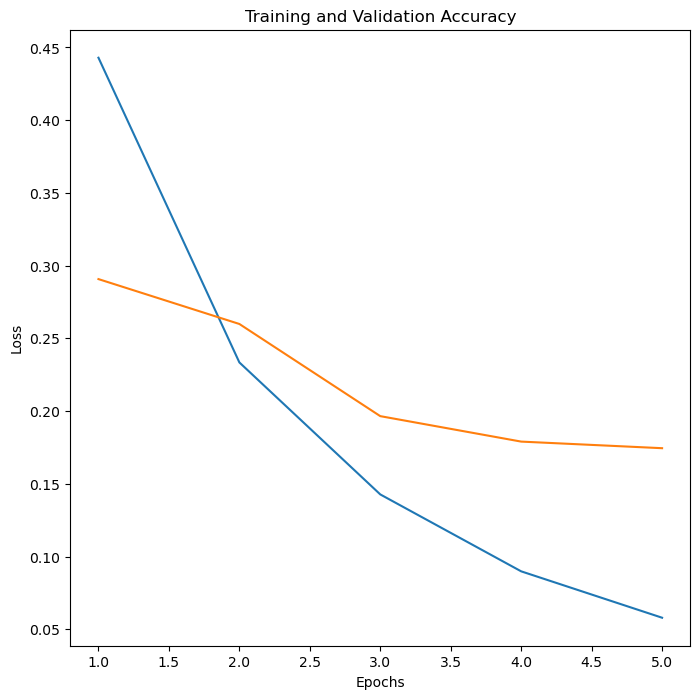

In [26]:
 
# Rest of your code...
epochs = range(1, EPOCHS + 1)
plt.figure(figsize=(8, 8))
plt.plot(epochs, train_loss_per_epoch, label='training loss')
plt.plot(epochs, val_loss_per_epoch, label='validation loss')
plt.title("Training and Validation Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Loss')
# Save the plot as a PNG file
plt.savefig('./loss_plotBig_bird_new_data.png')


In [27]:
valid_true = [batch["label"].detach().cpu().numpy() for batch in test_loader]
valid_true = np.concatenate(valid_true)
# valid_true = np.argmax(valid_true)

In [28]:
from sklearn.metrics import classification_report
print(classification_report(valid_pred, valid_true,labels=[0,1,2], target_names= ["level 1","level 2","level 3"]))

              precision    recall  f1-score   support

     level 1       0.97      0.97      0.97     10544
     level 2       0.97      0.97      0.97     11245
     level 3       0.98      0.98      0.98     13023

    accuracy                           0.97     34812
   macro avg       0.97      0.97      0.97     34812
weighted avg       0.97      0.97      0.97     34812



In [29]:
model.save_pretrained("./savedmodel_2")
tokenizer.save_pretrained("./savedmodel_2/")


('./savedmodel_2/tokenizer_config.json',
 './savedmodel_2/special_tokens_map.json',
 './savedmodel_2/spiece.model',
 './savedmodel_2/added_tokens.json')

In [5]:
# from transformers import BigBirdModel, BigBirdTokenizer
# # Load the saved model
# model = BigBirdModel.from_pretrained("./savedmodel")
# # Load the saved tokenizer
# tokenizer = BigBirdTokenizer.from_pretrained("./savedmodel/")


Some weights of the model checkpoint at ./savedmodel were not used when initializing BigBirdModel: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias']
- This IS expected if you are initializing BigBirdModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BigBirdModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
unique_levels = Data_csv['level'].unique()
new_df = pd.DataFrame(columns=Data_csv.columns)
for level in unique_levels:
    level_docs = Data_csv[Data_csv['level'] == level]
    level_docs_not_in_sample = level_docs[~level_docs.index.isin(sample_df.index)]
    selected_docs = level_docs_not_in_sample.sample(5)
    new_df = new_df.append(selected_docs)


In [ ]:
chunks = text_splitter_1.split_text(x)
    # length_total_labels += len(chunks)
    tokenized_chunks = []
    for chunk in chunks:
        # print("chunk_length",len(chunk.split()))
        chunk_len_list.append(len(chunk.split()))
        tokens = tokenizer(chunk, truncation=True, padding=True, return_tensors="pt")
        if len(tokens['input_ids'][0]) > 512:
            sub_chunks = text_splitter_2.split_text(chunk)
            print(len(sub_chunks))
            for i in sub_chunks:
                tokens = tokenizer(chunk, truncation=True, padding=True, return_tensors="pt")
                tokenized_chunks.append(tokens)
            # print(len(tokens['input_ids'][0]))
        else:
            token_len_list.append(len(tokens['input_ids'][0]))
            tokenized_chunks.append(tokens)
    input_id_chunks = []
    mask_chunks = []
    for chunk in tokenized_chunks:
        input_id_chunks.extend(chunk["input_ids"])
        mask_chunks.extend(chunk["attention_mask"])
    add_padding_tokens(input_id_chunks, mask_chunks)
    label_vec = [label] * len(input_id_chunks)
    total_chunks.extend((input_id_chunks))
    total_att_mask.extend((mask_chunks))
    total_labels.extend((label_vec))


In [20]:

import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from sklearn.preprocessing import OneHotEncoder
import torch
import torch.nn.functional as F
from langchain.text_splitter import TokenTextSplitter
text_splitter_1 = TokenTextSplitter(chunk_size=300, chunk_overlap=128)
text_splitter_2 = TokenTextSplitter(chunk_size=150, chunk_overlap=64)
label2id = {"Level 1": 0, "Level 2": 1, "Level 3": 2}
id_to_label = {v: k for k, v in label2id.items()}
# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("./savedmodel_2/")
model = AutoModelForSequenceClassification.from_pretrained("./savedmodel_2/")
# Create empty lists to store the predicted labels for each row

sample_df = Data_csv.groupby("level").apply(lambda x: x.sample(20))
true_labels = []
predicted_labels = []
# Iterate over each row in the dataframe
# for index, row in Data_csv.iterrows():

for idx in range(sample_df.shape[0]):
    print(idx)
    document = sample_df["text"].iloc[idx]
    label = label2id[sample_df.iloc[idx]["level"]]
    true_labels.append(label)
    chunks = text_splitter_1.split_text(document)
    tokenized_chunks = []
    for chunk in chunks:
        tokens = tokenizer(chunk, truncation=True, padding=True, return_tensors="pt")
        if len(tokens['input_ids'][0]) > 512:
            sub_chunks = text_splitter_2.split_text(chunk)
            print(len(sub_chunks))
            for i in sub_chunks:
                tokens = tokenizer(chunk, truncation=True, padding=True, return_tensors="pt")
                tokenized_chunks.append(tokens)
        else:
            tokenized_chunks.append(tokens)
    chunk_predicted_labels = []
    for tokens in tokenized_chunks:
        outputs = model(**tokens)
        # Get the predicted class index
        predicted_class_index = outputs.logits.argmax().item()
        # Get the predicted class label
        label2id = {"Level 1": 0, "Level 2": 1, "Level 3": 2}
        id_to_label = {v: k for k, v in label2id.items()}
        predicted_class_label = id_to_label[predicted_class_index]
        chunk_predicted_labels.append(predicted_class_label)
    # Find the majority predicted label for all the chunks
    majority_label = max(set(chunk_predicted_labels), key=chunk_predicted_labels.count)
    predicted_labels.append(majority_label)
    print(predicted_class_label)
    print("True label vs predicted label",id_to_label[label],majority_label)
# Count the occurrence of each predicted label
label_counts = pd.Series(predicted_labels).value_counts()
print(label_counts)


0


Attention type 'block_sparse' is not possible if sequence_length: 285 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...


Level 1
True label vs predicted label Level 1 Level 1
1
Level 1
True label vs predicted label Level 1 Level 1
2
Level 2
True label vs predicted label Level 1 Level 2
3
Level 1
True label vs predicted label Level 1 Level 1
4
Level 1
True label vs predicted label Level 1 Level 1
5
Level 1
True label vs predicted label Level 1 Level 2
6
Level 1
True label vs predicted label Level 1 Level 1
7
Level 1
True label vs predicted label Level 1 Level 1
8
Level 1
True label vs predicted label Level 1 Level 2
9
Level 3
True label vs predicted label Level 1 Level 1
10
Level 2
True label vs predicted label Level 1 Level 1
11
Level 1
True label vs predicted label Level 1 Level 1
12
Level 1
True label vs predicted label Level 1 Level 1
13
Level 2
True label vs predicted label Level 1 Level 1
14
Level 1
True label vs predicted label Level 1 Level 1
15
Level 1
True label vs predicted label Level 1 Level 1
16
Level 3
True label vs predicted label Level 1 Level 2
17
Level 1
True label vs predicted label Le

In [ ]:
unique_levels = Data_csv['level'].unique()
new_df = pd.DataFrame(columns=Data_csv.columns)
for level in unique_levels:
    level_docs = Data_csv[Data_csv['level'] == level]
    level_docs_not_in_sample = level_docs[~level_docs.index.isin(sample_df.index)]
    selected_docs = level_docs_not_in_sample.sample(5)
    new_df = new_df.append(selected_docs)


In [65]:
Data_csv

,filename,text,level
0,15031-4983-FullBook.docx,"Learner Choice, Learning Voice\n\n\nLearner Vo...",Level 1
1,15031-4984-FullBook.docx,\n\nExistentialism: A Philosophical Inquiry\n\...,Level 1
2,15031-4985-FullBook.docx,"""The editors of this volume are the top practi...",Level 1
3,15031-4986-FullBook.docx,Black Power Music!\n\nBlack Power Music!: Prot...,Level 1
4,15031-4989-FullBook.docx,Home\n\n\nHome articulates a ‘critical geograp...,Level 1
...,...,...,...
1231,15032-5774-FullBook.docx,The Japanese LGBTQ+ Community in the World\n\n...,Level 3
1232,15032-5789-FullBook.docx,The Acquisition of English Grammar and Phonolo...,Level 3
1233,15032-5829-FullBook.docx,"\n‘New concepts, new words for them, new actio...",Level 3
1234,15032-5843-FullBook.docx,Translating Rumi into the West\n\n\nFocusing o...,Level 3


In [3]:
import pandas as pd

# Read the CSV file containing the filenames
excluded_filenames_df = pd.read_csv('./ddp/selected_samples.csv')

# Extract the filenames from the dataframe as a list
excluded_filenames = excluded_filenames_df['filename'].tolist()

# Print the list of excluded filenames
print(excluded_filenames)

['15032-5476-FullBook.docx', '15032-5854-FullBook.docx', '15032-5725-FullBook.docx', '15032-5362-FullBook.docx', '15032-5709-FullBook.docx', '15031-5538-FullBook.docx', '15031-5366-FullBook.docx', '15031-5012-FullBook.docx', '15032-5490-FullBook.docx', '15031-5043-FullBook.docx', '15031-5495-FullBook.docx', '15031-5259-FullBook.docx', '15031-5456-FullBook.docx', '15032-5538-FullBook.docx', '15032-5283-FullBook.docx', '15032-5308-FullBook.docx', '15032-5512-FullBook.docx', '15032-5900-FullBook.docx', '15031-5310-FullBook.docx', '15032-5318-FullBook.docx', '15031-5296-FullBook.docx', '15032-5695-FullBook.docx', '15032-5459-FullBook.docx', '15032-5898-FullBook.docx', '15031-5189-FullBook.docx', '15031-5307-FullBook.docx', '15032-5372-FullBook.docx', '15031-5347-FullBook.docx', '15032-5196-FullBook.docx', '15032-5883-FullBook.docx', '15031-5002-FullBook.docx', '15032-5481-FullBook.docx', '15032-5856-FullBook.docx', '15032-5861-FullBook.docx', '15031-5545-FullBook.docx', '15032-5298-FullBoo

In [4]:
new_df = Data_csv[~Data_csv['filename'].isin(excluded_filenames)]

# Print the new dataframe
# print(new_df)

In [5]:
new_df

,filename,text,level
0,15031-4983-FullBook.docx,"Learner Choice, Learning Voice\n\n\nLearner Vo...",Level 1
1,15031-4984-FullBook.docx,\n\nExistentialism: A Philosophical Inquiry\n\...,Level 1
2,15031-4985-FullBook.docx,"""The editors of this volume are the top practi...",Level 1
3,15031-4986-FullBook.docx,Black Power Music!\n\nBlack Power Music!: Prot...,Level 1
4,15031-4989-FullBook.docx,Home\n\n\nHome articulates a ‘critical geograp...,Level 1
...,...,...,...
1178,15031-5136-FullBook.docx,An Introduction to Arabic Translation\n\n\nCom...,Level 3
1195,15031-5264-FullBook.docx,Modern Cantonese Book 1\n\n\nThe first volume ...,Level 3
1205,15031-5354-FullBook.docx,Fundamentals of the Persian Alphabet\n\nFundam...,Level 3
1217,15032-5365-FullBook.docx,Border Regimes in Twentieth Century Europe\n\n...,Level 3


In [50]:
new_rows = []
for index, row in Data_csv.iterrows():
    if row['filename'] not in exclude_list:
        new_rows.append(row)

new_df = pd.concat(new_rows, axis=1).T

In [56]:
sample_df["filename"].to_csv('./savedmodel_2/sample_df.csv', index=False)

In [8]:


tokenizer = AutoTokenizer.from_pretrained("./ddp/savedmodel_multi_gpu_ddp/")
model = AutoModelForSequenceClassification.from_pretrained("./ddp/savedmodel_multi_gpu_ddp/")

In [9]:

import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from sklearn.preprocessing import OneHotEncoder
import torch
import torch.nn.functional as F
from langchain.text_splitter import TokenTextSplitter
text_splitter_1 = TokenTextSplitter(chunk_size=300, chunk_overlap=128)
text_splitter_2 = TokenTextSplitter(chunk_size=150, chunk_overlap=64)
label2id = {"Level 1": 0, "Level 2": 1, "Level 3": 2}
id_to_label = {v: k for k, v in label2id.items()}
# Load the tokenizer and model
# tokenizer = AutoTokenizer.from_pretrained("./savedmodel_2/")
# model = AutoModelForSequenceClassification.from_pretrained("./savedmodel_2/")
# Create empty lists to store the predicted labels for each row

# sample_df = Data_csv.groupby("level").apply(lambda x: x.sample(20))
true_labels = []
predicted_labels = []
# Iterate over each row in the dataframe
# for index, row in Data_csv.iterrows():
print(range(new_df.shape[0]))
for idx in range(422,new_df.shape[0]):
    print(idx)
    document = new_df["text"].iloc[idx]
    label = label2id[new_df.iloc[idx]["level"]]
    true_labels.append(label)
    chunks = text_splitter_1.split_text(document)
    tokenized_chunks = []
    for chunk in chunks:
        tokens = tokenizer(chunk, truncation=True, padding=True, return_tensors="pt")
        if len(tokens['input_ids'][0]) > 512:
            sub_chunks = text_splitter_2.split_text(chunk)
            print(len(sub_chunks))
            for i in sub_chunks:
                tokens = tokenizer(chunk, truncation=True, padding=True, return_tensors="pt")
                tokenized_chunks.append(tokens)
        else:
            tokenized_chunks.append(tokens)
    chunk_predicted_labels = []
    for tokens in tokenized_chunks:
        outputs = model(**tokens)
        # Get the predicted class index
        predicted_class_index = outputs.logits.argmax().item()
        # Get the predicted class label
        label2id = {"Level 1": 0, "Level 2": 1, "Level 3": 2}
        id_to_label = {v: k for k, v in label2id.items()}
        predicted_class_label = id_to_label[predicted_class_index]
        chunk_predicted_labels.append(predicted_class_label)
    # Find the majority predicted label for all the chunks
    majority_label = max(set(chunk_predicted_labels), key=chunk_predicted_labels.count)
    predicted_labels.append(majority_label)
    print(predicted_class_label)
    print("True label vs predicted label", new_df["filename"].iloc[idx],id_to_label[label],majority_label)
# Count the occurrence of each predicted label
label_counts = pd.Series(predicted_labels).value_counts()
print(label_counts)


range(0, 1006)
422


Attention type 'block_sparse' is not possible if sequence_length: 300 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...


Level 1
True label vs predicted label 15032-5340-FullBook.docx Level 1 Level 1
423
Level 1
True label vs predicted label 15032-5341-FullBook.docx Level 1 Level 1
424
Level 1
True label vs predicted label 15032-5342-FullBook.docx Level 1 Level 1
425
Level 1
True label vs predicted label 15032-5344-FullBook.docx Level 1 Level 1
426
Level 1
True label vs predicted label 15032-5347-FullBook.docx Level 1 Level 1
427
Level 1
True label vs predicted label 15032-5348-FullBook.docx Level 1 Level 1
428
Level 1
True label vs predicted label 15032-5349-FullBook.docx Level 1 Level 1
429
Level 2
True label vs predicted label 15032-5350-FullBook.docx Level 1 Level 1
430
Level 3
True label vs predicted label 15032-5351-FullBook.docx Level 1 Level 1
431
Level 2
True label vs predicted label 15032-5352-FullBook.docx Level 1 Level 1
432
Level 1
True label vs predicted label 15032-5353-FullBook.docx Level 1 Level 1
433
Level 1
True label vs predicted label 15032-5354-FullBook.docx Level 1 Level 1
434
Leve

In [ ]:
# exclude_list = list(sample_df['filename'])

# new_df =pd.DataFrame(columns=Data_csv.columns)

# for index, row in Data_csv.iterrows():
#     if row['filename'] not in exclude_list:
#         new_df = new_df.append(row)


# # if 'filename' in Data_csv.columns:
# #     # Filter out the rows with filenames in the exclude_list
# #     new_df = Data_csv[~Data_csv['filename'].isin(exclude_list)]
# # else:
# #     # If the 'filename' column is not present, use a different column name or adjust the code accordingly
# #     new_df = Data_csv.copy()

# # # Print the new dataframe
# # print(new_df)

In [58]:
import pandas as pd

# Read the CSV file into a dataframe
Data_csv = pd.read_csv("/home/ubuntu/cat_poc/llms/final_data.csv")

# Select a specific number of samples from each level
num_samples_level1 = 85
num_samples_level2 = 85
num_samples_level3 = 60

# Create a new dataframe to store the selected samples
sample_df = pd.DataFrame()

# Select samples from Level 1
level1_samples = Data_csv[Data_csv['level'] == 'Level 1'].sample(num_samples_level1)
sample_df = sample_df.append(level1_samples)

# Select samples from Level 2
level2_samples = Data_csv[Data_csv['level'] == 'Level 2'].sample(num_samples_level2)
sample_df = sample_df.append(level2_samples)

# Select samples from Level 3
level3_samples = Data_csv[Data_csv['level'] == 'Level 3'].sample(num_samples_level3)
sample_df = sample_df.append(level3_samples)
# Reset the index of the new dataframe
sample_df = sample_df.reset_index(drop=True)


/tmp/ipykernel_1637831/2051457931.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sample_df = sample_df.append(level1_samples)
/tmp/ipykernel_1637831/2051457931.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sample_df = sample_df.append(level2_samples)
/tmp/ipykernel_1637831/2051457931.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sample_df = sample_df.append(level3_samples)


In [59]:
sample_df

,filename,text,level
0,15031-5308-FullBook.docx,Veganism and Eating Disorder Recovery\nThis bo...,Level 1
1,15032-5740-FullBook.docx,"Performance, Resistance and Refugees \n\nThis ...",Level 1
2,15031-5416-FullBook.docx,ENDORSEMENTS\n\nA sense of wonder permeates ev...,Level 1
3,15032-5882-FullBook.docx,Reason in the Service of Faith\n\nPaul Helm is...,Level 1
4,15031-5022-FullBook.docx,"""Liow’s expertise and judgment combine to make...",Level 1
...,...,...,...
225,15031-5052-FullBook.docx,The History of Chinese Rhetoric\n\n\nThis book...,Level 3
226,15031-5261-FullBook.docx,Jin Chinese Grammar II\n\nThis book is the sec...,Level 3
227,15031-5319-FullBook.docx,<<halftitle page i – mandatory element>>\nMode...,Level 3
228,15031-5274-FullBook.docx,<<RUN BOOKMARK AS PER ORDER>>\nTeach\n\nIs tea...,Level 3
